<a href="https://colab.research.google.com/github/Felimartinez1/Voice-Cloning/blob/main/Voice_Cloning_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bark Notebook

>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Setting

In [ ]:
!pip install git+https://github.com/suno-ai/bark.git
!git clone https://github.com/gitmylo/bark-voice-cloning-HuBERT-quantizer
!pip install -r ./bark-voice-cloning-HuBERT-quantizer/requirements.txt
!pip install pydub
!pip install TTS
!pip install pesq

  Cloning https://github.com/suno-ai/bark.git to /tmp/pip-req-build-hjahljwo
  Running command git clone --filter=blob:none --quiet https://github.com/suno-ai/bark.git /tmp/pip-req-build-hjahljwo
  Resolved https://github.com/suno-ai/bark.git to commit 773624d26db84278a55aacae9a16d7b25fbccab8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 23.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 59.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 7.2 MB/s eta 0:00:00
  Created wheel for suno-bark: filename=suno_bark-0.0.1a0-py3-none-any.whl size=2567

  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=262934 sha256=eac210ccc8e1113ae8041c91f980cf3c4350296f23b0f00ae48fd987a00d60e8
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [ ]:
# System libs
import sys
import os
from subprocess import call



# Data analyisis libs
import torch
import numpy as np


# Model / TTS Libs
sys.path.append('./bark-voice-cloning-HuBERT-quantizer')
from bark.api import generate_audio
from bark.generation import SAMPLE_RATE, preload_models, load_codec_model
from encodec.utils import convert_audio
from bark_hubert_quantizer.customtokenizer import CustomTokenizer
from bark_hubert_quantizer.hubert_manager import HuBERTManager
from bark_hubert_quantizer.pre_kmeans_hubert import CustomHubert

from TTS.tts.utils.helpers import StandardScaler
from TTS.config import BaseAudioConfig
from TTS.utils.audio.processor import AudioProcessor
from TTS.utils.audio.numpy_transforms import *


# Visualización

import IPython
import matplotlib.pyplot as plt



# Audio Libs
from io import BytesIO
import scipy.io.wavfile
from scipy.io.wavfile import write as write_wav
from scipy.signal import wiener
import soundfile as sf
import librosa
import librosa.display
from librosa.core import griffinlim
from pydub import AudioSegment
from scipy.signal import medfilt
import torchaudio




In [ ]:
def config():
  device = 'cuda' if torch.cuda.is_available() else 'cpu'
  use_gpu = True if device == 'cuda' else False
  model = load_codec_model(use_gpu=use_gpu)

  preload_models(
      text_use_gpu=use_gpu,
      text_use_small=False,
      coarse_use_gpu=use_gpu,
      coarse_use_small=False,
      fine_use_gpu=use_gpu,
      fine_use_small=False,
      codec_use_gpu=use_gpu,
      force_reload=False
  )

  hubert_manager = HuBERTManager()
  hubert_manager.make_sure_hubert_installed()
  hubert_manager.make_sure_tokenizer_installed()

  # Load the HuBERT model
  hubert_model = CustomHubert(checkpoint_path='data/models/hubert/hubert.pt').to(device)

  # Load the CustomTokenizer model
  tokenizer = CustomTokenizer.load_from_checkpoint('/content/drive/MyDrive/Voice Cloning Master/data/models/hubert/es_tokenizer.pth', map_location=device).to(device)
  return model, hubert_model, tokenizer, device

model, hubert_model, tokenizer, device = config()

/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Downloading: "https://dl.fbaipublicfiles.com/encodec/v0/encodec_24khz-d7cc33bc.th" to /root/.cache/torch/hub/checkpoints/encodec_24khz-d7cc33bc.th
100%|██████████| 88.9M/88.9M [00:00<00:00, 104MB/s]


text_2.pt:   0%|          | 0.00/5.35G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

coarse_2.pt:   0%|          | 0.00/3.93G [00:00<?, ?B/s]

fine_2.pt:   0%|          | 0.00/3.74G [00:00<?, ?B/s]

Downloaded HuBERT


quantifier_hubert_base_ls960_14.pth:   0%|          | 0.00/104M [00:00<?, ?B/s]

Downloaded tokenizer


/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


## Preparing data

In [ ]:

def convert_folder_to_wav(folder):
    for file in os.listdir(folder):
        if file.endswith('.m4a'):
            call(['ffmpeg', '-i', folder + '/' + file, folder + '/' + file.replace('.m4a', '.wav')])
            os.remove(folder + '/' + file)

convert_folder_to_wav('/content/')


In [ ]:

def ogg_to_wav(input_file, output_file):
    # Cargar el archivo OGG
    audio = AudioSegment.from_ogg(input_file)

    # Exportar como WAV
    audio.export(output_file, format="wav")

# Especifica la ruta del archivo OGG de entrada y la ruta de salida para el archivo WAV
input_ogg_file = "/content/valeria.ogg"
output_wav_file = "/content/valeria.wav"

# Llama a la función de conversión
ogg_to_wav(input_ogg_file, output_wav_file)

In [ ]:


def cut_audio(input_path, output_path, start_ms, end_ms):
    # Cargar el audio
    audio = AudioSegment.from_file(input_path)

    # Cortar el audio
    audio_cortado = audio[start_ms:end_ms]

    # Guardar el audio cortado
    audio_cortado.export(output_path, format="wav")

# Especificar las rutas de entrada y salida, y los tiempos de inicio y fin en milisegundos
input_path = "/content/valeria.wav"
output_path = "/content/valeria_cut.wav"
start_ms = 0  # tiempo de inicio en milisegundos
end_ms = 12000  # tiempo de fin en milisegundos

# Llamar a la función para cortar el audio
cut_audio(input_path, output_path, start_ms, end_ms)

IPython.display.Audio('/content/valeria_cut.wav')

## Preprocessing

no me preguntes que es  lo que hace esto pero se le pueden hacer modificaciones.

In [ ]:

def preprocess_audio(audio_path, output_path, target_sr=48000):
    # Cargar el archivo de audio
    y, sr = librosa.load(audio_path, sr=None)

    # Normalizar el volumen
    y = librosa.util.normalize(y)

    # Aplicar reducción de ruido utilizando filtro de mediana
    y = medfilt(y, kernel_size=3)

    # Cambiar la velocidad (pitch) del audio para mejorar la variabilidad
    y = librosa.effects.pitch_shift(y=y, sr=sr, n_steps=np.random.uniform(-2.0, 2.0))

    # Filtrar frecuencias bajas y altas
    y = librosa.effects.preemphasis(y, coef=0.97)

    # Cambiar la tasa de muestreo
    if sr != target_sr:
        y = librosa.resample(y=y, orig_sr=sr, target_sr=target_sr)

    # Guardar el audio preprocesado con soundfile
    sf.write(output_path, y, target_sr)

# Ejemplo de uso
audio_path = '/content/cut_noe_corregido.wav'
output_path = '/content/noe_preprocesado.wav'

preprocess_audio(audio_path, output_path)


In [ ]:
IPython.display.Audio('noe_preprocesado.wav')

Esto es con el repo de coqui-tts

In [ ]:
conf = BaseAudioConfig(pitch_fmax=640, pitch_fmin=1)
ap = AudioProcessor(**conf)
def reconstruct_audio(conf, ap, wav_path, output_path):
  wav, sr = librosa.load(wav_path, sr=None)

  # Normalizar volumen
  wav = ap.rms_volume_norm(wav, db_level=-30)

  # Recortar silencio
  wav = ap.trim_silence(wav)

  # Aplicar preénfasis
  wav = preemphasis(x=wav, coef=np.array([0.97]))

  # Convertir los datos de audio a punto flotante
  wav = np.asarray(wav, dtype=np.float32)
  wav = librosa.util.normalize(wav)

  # Calcular mel-espectrograma
  mel_spec = ap.melspectrogram(wav)

  # Convertir amplitud a dB
  # Limitar los valores del espectrograma de amplitud a un rango mínimo positivo
  mel_spec_clipped = np.clip(mel_spec, a_min=1e-8, a_max=None)

  # Convertir amplitud a dB
  mel_spec_db = amp_to_db(x=mel_spec_clipped)
  # Guardar el mel-spectrogram como un archivo NumPy
  output_path_without_extension, _ = os.path.splitext(output_path)
  np.save(f'{output_path_without_extension}_preprocessed.npy', mel_spec_db)

  # Load the mel-spectrogram data
  mel_spec_db = np.load('/content/chris_preprocessed.npy')

  # Convert mel-spectrogram back to linear scale
  mel_spec_linear = librosa.db_to_amplitude(mel_spec_db)

  # Reconstruct audio using Griffin-Lim algorithm
  audio_reconstructed = griffinlim(mel_spec_linear.T)

  # Save the reconstructed audio
  output_path_without_extension, _ = os.path.splitext(output_path)
  sf.write(f'{output_path_without_extension}_reconstructed.wav', audio_reconstructed, sr)


Corrección de ruido

In [ ]:
def corregir_ruido(audio_path, audio_output, sr=None):
  # Cargar el archivo de audio y obtener la forma de onda y la tasa de muestreo
  y, sr = librosa.load(audio_path, sr=None)

  # Aplicar el filtro de Wiener para reducir el ruido
  y_clean = wiener(y)

  # Guardar el archivo de audio limpio con soundfile
  sf.write(audio_output, y_clean, sr)

corregir_ruido('cut_noe.wav','cut_noe_corregido.wav')

In [ ]:
IPython.display.Audio('cut_noe_corregido.wav')

Score de calidad del output (no es tan copado)

In [ ]:
!pip install pesq

In [ ]:

def score_pesq(audio_path, audio_path2):
  # Cargar el archivo de audio y obtener la forma de onda y la tasa de muestreo
  y1, sr1 = librosa.load(audio_path, sr=16000)
  y2, sr2 = librosa.load(audio_path2, sr=16000)
  # Calcular la métrica PESQ
  pesq_score_1 = pesq(sr1, y1, y2)
  return pesq_score_1

score_pesq('/content/cesar.wav', '/content/clon.wav')

NameError: ignored

## Inference

In [ ]:
def inference(text_prompt, audio_filepath, output_path, model, device, text_temp=0.7, waveform_temp=0.7):
  if not os.path.isfile(audio_filepath):
    raise ValueError(f"Audio file not exists ({audio_filepath})")
  wav, sr = torchaudio.load(audio_filepath)
  wav = convert_audio(wav, sr, model.sample_rate, model.channels)
  wav = wav.to(device)

  semantic_vectors = hubert_model.forward(wav, input_sample_hz=model.sample_rate)
  semantic_tokens = tokenizer.get_token(semantic_vectors)

  # Extract discrete codes from EnCodec
  with torch.no_grad():
      encoded_frames = model.encode(wav.unsqueeze(0))
  codes = torch.cat([encoded[0] for encoded in encoded_frames], dim=-1).squeeze()

  # move codes to cpu
  codes = codes.cpu().numpy()
  # move semantic tokens to cpu
  semantic_tokens = semantic_tokens.cpu().numpy()

  voice_filename = 'processed.npz'

  current_path = os.getcwd()
  voice_name = os.path.join(current_path, voice_filename)

  np.savez(voice_name, fine_prompt=codes, coarse_prompt=codes[:2, :], semantic_prompt=semantic_tokens)

  # simple generation
  audio_array = generate_audio(text_prompt, history_prompt=voice_name, text_temp=0.7, waveform_temp=0.7)

  # save audio
  write_wav(output_path, SAMPLE_RATE, audio_array)
  return audio_array

inference("Hija dejá de romperme las pelotas.", "valeria.wav","clon1.wav", model, device)

100%|██████████| 28/28 [00:24<00:00,  1.14it/s]


array([-0.0021816 , -0.00168187, -0.00261718, ..., -0.00613362,
       -0.0092134 , -0.01312476], dtype=float32)

In [ ]:
IPython.display.Audio(filename="clon.wav")

In [ ]:
IPython.display.Audio(filename="clon1.wav")

In [ ]:
IPython.display.Audio(filename="valeria.wav")

## Vizz

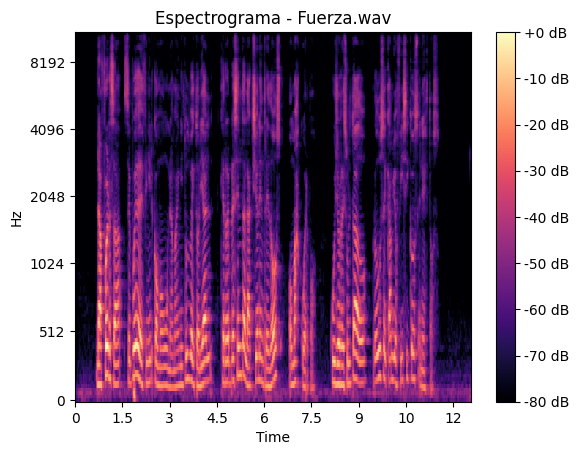

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import numpy as np

# Lista de nombres de archivos
archivos = ["Fuerza.wav"]

def plot_espectrograma(audio_path):
    y, sr = librosa.load(audio_path)
    espectrograma = librosa.feature.melspectrogram(y=y, sr=sr)
    librosa.display.specshow(librosa.power_to_db(espectrograma, ref=np.max), y_axis='mel', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Espectrograma - ' + os.path.basename(audio_path))
    plt.show()

# Iterar sobre la lista de archivos y generar gráficos
for archivo in archivos:
    audio_path = "/content/" + archivo  # Ajusta la ruta según tu estructura de carpetas
    plot_espectrograma(audio_path)

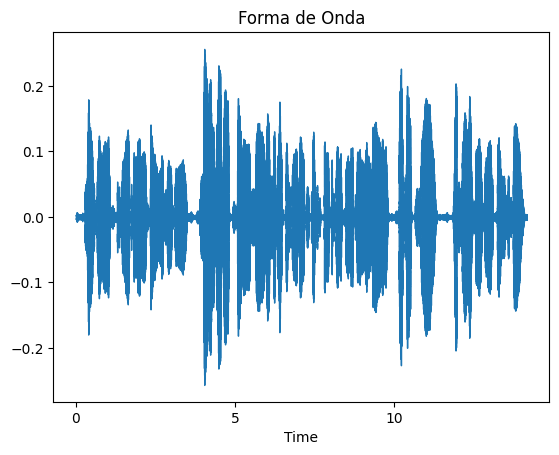

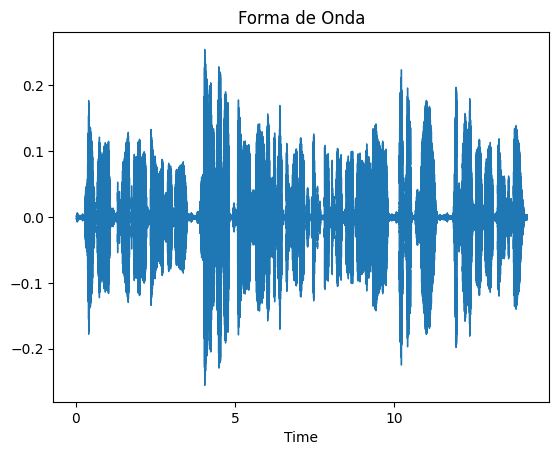

In [ ]:
def plot_forma_onda(audio_path):
    y, sr = librosa.load(audio_path)
    librosa.display.waveshow(y, sr=sr)
    plt.title('Forma de Onda')
    plt.show()

plot_forma_onda('/content/5.wav')
plot_forma_onda('/content/5_preprocessed.wav')